In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import re
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [2]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
RCC = pd.read_csv('MergeData/all_sheets_merge1.csv')
pca = PCA(n_components=20)
sm = SMOTE(random_state = 12)
RCC['性別'] = RCC['性別'].map({'F':0,'M':1})
y = RCC['呼吸器成功脫離']
RCC = RCC.drop(['呼吸器成功脫離'], axis=1)

In [3]:
RCC.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in RCC.columns.values]
RCC = RCC.fillna(0)

In [4]:
reduced_data_pca = pca.fit_transform(RCC)
xgbc = XGBClassifier()
#np.any(np.isnan(RCC))
X_train, X_test, y_train, y_test = train_test_split(reduced_data_pca, y, test_size=0.25, random_state=33)

In [5]:
x_train_res,y_train_res = sm.fit_sample(X_train,y_train)

In [6]:
#rfc = RandomForestClassifier()
#rfc.fit(X_train,y_train)
#print('The accuracy of Random Forest Classifier on testing set:', rfc.score(X_test, y_test))

In [7]:
xgbc.fit(x_train_res, y_train_res)
print('The accuracy of eXtreme Gradient Boosting Classifier on testing set:', xgbc.score(X_test, y_test))

The accuracy of eXtreme Gradient Boosting Classifier on testing set: 0.6363636363636364


In [8]:
kf = KFold(n_splits=10)
kf_scores = []
for train_index, test_index in kf.split(RCC):
    X_train, X_test = RCC.iloc[train_index], RCC.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    x_train_res,y_train_res = sm.fit_sample(X_train,y_train)
    xgbc.fit(x_train_res, y_train_res)
    kf_scores.append(xgbc.score(X_test, y_test))

In [9]:
print(kf_scores)
print(np.mean(kf_scores))
print(np.std(kf_scores))

[0.6363636363636364, 0.7727272727272727, 0.6363636363636364, 0.7727272727272727, 0.8181818181818182, 0.7727272727272727, 0.9090909090909091, 0.8181818181818182, 0.7272727272727273, 0.8636363636363636]
0.7727272727272727
0.08381404052084443


In [10]:
import seaborn as sns; sns.set()
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam
import pylab as plt

In [11]:
RCC.shape

(220, 2363)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(RCC, y, test_size=0.25, random_state=33)
m = Sequential()
m.add(Dense(512,  activation='elu', input_shape=(2363,)))
m.add(Dense(128,  activation='elu'))
m.add(Dense(2,    activation='linear', name="bottleneck"))
m.add(Dense(128,  activation='elu'))
m.add(Dense(512,  activation='elu'))
m.add(Dense(2363,  activation='sigmoid'))
m.compile(loss='mean_squared_error', optimizer = Adam())

history = m.fit(x_train, x_train, batch_size=128, epochs=5, verbose=1,validation_data=(x_train, x_train))
encoder = Model(m.input, m.get_layer('bottleneck').output)
Zenc = encoder.predict(x_train)  # bottleneck representation
Renc = m.predict(x_train)        # recons

Train on 165 samples, validate on 165 samples
Epoch 1/5
165/165 [==============================] - 0s 2ms/step - loss: 2164997.9152 - val_loss: 2164833.9023
Epoch 2/5
165/165 [==============================] - 0s 612us/step - loss: 2164826.5909 - val_loss: 2164795.0894
Epoch 3/5
165/165 [==============================] - 0s 648us/step - loss: 2164792.5758 - val_loss: 2164782.8955
Epoch 4/5
165/165 [==============================] - 0s 733us/step - loss: 2164781.6909 - val_loss: 2164748.2318
Epoch 5/5
165/165 [==============================] - 0s 751us/step - loss: 2164746.6288 - val_loss: 2164737.3674


In [26]:
m.evaluate(x_train,x_train,batch_size=128, verbose=1, sample_weight=None)
history

165/165 [==============================] - 0s 151us/step


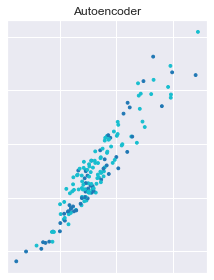

In [17]:
plt.subplot(122)
plt.title('Autoencoder')
plt.scatter(Zenc[:5000,0], Zenc[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])
plt.tight_layout()

In [23]:
predictions_NN_prob = m.predict(x_test)

In [24]:
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc

In [25]:
predictions_NN_prob = predictions_NN_prob[:,0]
predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

#Print accuracy
acc_NN = accuracy_score(y_test, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN)

Overall accuracy of Neural Network model: 0.6545454545454545
